In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import sys
from tqdm import tqdm

from ExptTrace import ExptTrace
from misc import rcsetup

rcsetup()

sys.path.append("../")
from data import get_powerlaw
from utils import ensure_torch, ensure_numpy
from feature_decomp import generate_fra_monomials
from kernels import GaussianKernel, krr
from eigenlearning import eigenlearning


In [31]:
# learning problem: choose sufficiently large P and recover vstar[:P] from y and H
def recover_coeffs(H, y, strategy='optimal', **kwargs):
    """
    Recover coefficients from the data matrix H and target vector y.
    The strategy can be 'optimal' or 'ambitious'.
    """
    n = len(y)
    if strategy == 'optimal':
        source_exp = kwargs.get('source_exp', 1.05)
        P = int(n * (source_exp - 1) / source_exp)
    elif strategy == 'ambitious':
        frac = kwargs.get('frac', 0.25)
        P = int(frac * n)
    else:
        raise ValueError("Unknown strategy: {}".format(strategy))
    
    vhat = torch.linalg.lstsq(H[:, :P], y).solution    
    return vhat

In [38]:
M = 200_000         # function space dimension
n = 10_000           # number of samples
source_exp = 1.05

# random target function (components are function space coeffs)
# vstar \in R^M, ||vstar|| = 1
powerlaw = get_powerlaw(M, source_exp/2, offset=6)
vstar = ensure_torch(torch.normal(0, 1, (M,))) * powerlaw
vstar /= torch.linalg.norm(vstar)

# randomly sample vstar in data space (y_i = vstar(x_i))
# y \in R^n, y_i ~ O(1)
# tbh I should be adding y-noise to account for the missing tail, but whatever
H = ensure_torch(torch.normal(0, 1, (n, M)))
y = H @ vstar


In [39]:
# eigenlearning experiment

print("Constructing kernel")
data_dim = 1000
data_eigval_exp = 1.3
data_eigvals = get_powerlaw(data_dim, data_eigval_exp, offset=6)
eval_level_coeff = GaussianKernel.get_level_coeff_fn(data_eigvals, kernel_width=4)
kernel_eigvals, _ = generate_fra_monomials(data_eigvals, M, eval_level_coeff)

K = (H * ensure_torch(kernel_eigvals).unsqueeze(0)) @ H.T

def get_ntrials(ntrain):
    if ntrain < 100: return 20
    elif ntrain < 1000: return 10
    elif ntrain < 10000: return 5
    else: return 2

ntest = n // 20
log_ntrain_max = np.log10(n - ntest)
ntrains = np.unique(np.logspace(1, log_ntrain_max, base=10, num=20).astype(int))
ridge = 1e-3

var_axes = ["trial", "ntrain"]
et_yhat = ExptTrace(var_axes)

print("Beginning experiment")
for ntrain in tqdm(ntrains):
    for trial in range(get_ntrials(ntrain)):
        (y_hat, y_test), _ = krr(K, y, ntrain, n_test=ntest, ridge=ridge)
        et_yhat[trial, ntrain] = y_hat.cpu().numpy()


Constructing kernel
Beginning experiment


100%|██████████| 20/20 [00:14<00:00,  1.40it/s]


/opt/conda/lib/python3.10/site-packages/numpy/ma/core.py:6975: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


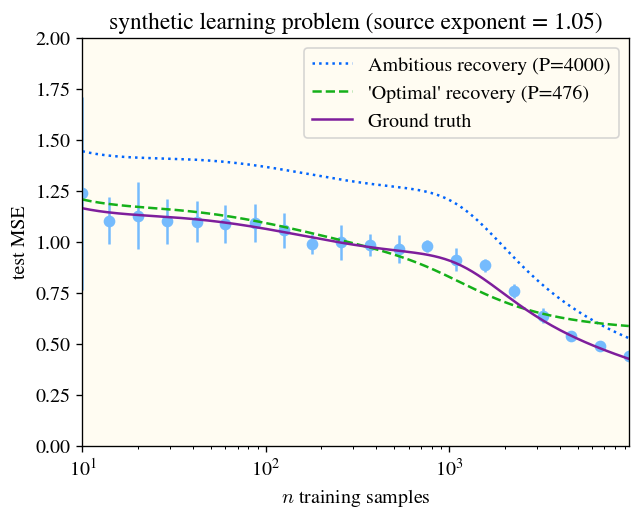

In [41]:
def get_coeff_stats(vstar, H, y, strategy, **kwargs):
    vhat = recover_coeffs(H, y, strategy=strategy, **kwargs)
    P = len(vhat)
    uncaptured = (vstar[P:]**2).sum().item()
    # mse = ((vhat - vstar[:P])**2).sum().item() + uncaptured
    return vhat, P, uncaptured

def compute_learning_curve(ntrains, kernel_eigvals, coeffs, ridge, noise_var):
    kernel_eigvals, coeffs = ensure_numpy(kernel_eigvals), ensure_numpy(coeffs)
    lrn_curve = [
        eigenlearning(n, kernel_eigvals, coeffs, ridge=ridge, noise_var=noise_var)["test_mse"]
        for n in ntrains
    ]
    return np.array(lrn_curve)

yhat = et_yhat[:, :].squeeze()
ystar = ensure_numpy(y)[-ntest:]
mse = ((yhat - ystar)**2).mean(axis=-1)
mse_mean, mse_std = mse.mean(axis=0), mse.std(axis=0)

recovery_frac = 0.4
vhat_amb, P_amb, nv_amb = get_coeff_stats(vstar, H, y, strategy='ambitious', frac=recovery_frac)
vhat_opt, P_opt, nv_opt = get_coeff_stats(vstar, H, y, strategy='optimal', source_exp=source_exp)

ntrains_dense = np.logspace(np.log10(ntrains[0]), np.log10(ntrains[-1]), 200)
lrn_curve_tru = compute_learning_curve(ntrains_dense, kernel_eigvals, vstar, ridge=ridge, noise_var=0)
lrn_curve_amb = compute_learning_curve(ntrains_dense, kernel_eigvals, vhat_amb, ridge=ridge, noise_var=nv_amb)
lrn_curve_opt = compute_learning_curve(ntrains_dense, kernel_eigvals, vhat_opt, ridge=ridge, noise_var=nv_opt)

fig, ax = plt.subplots(figsize=(5.5, 4.5))
colors = ['xkcd:bright blue', 'xkcd:aubergine', 'xkcd:pale red']
ax.errorbar(ntrains, mse_mean, yerr=mse_std, color='xkcd:sky blue',
            ls='none', marker='o', zorder=-4)

ax.plot(ntrains_dense, lrn_curve_amb, color='xkcd:bright blue', ls=":", label=f"Ambitious recovery (P={len(vhat_amb)})")
ax.plot(ntrains_dense, lrn_curve_opt, color='xkcd:green', ls="--", label=f"'Optimal' recovery (P={len(vhat_opt)})")
ax.plot(ntrains_dense, lrn_curve_tru, color='xkcd:purple', label="Ground truth")

ax.set_title(f"synthetic learning problem (source exponent = {source_exp})",
             fontsize=14)
ax.set_xlabel(f"$n$ training samples")
ax.set_ylabel("test MSE")
ax.set_xlim(ntrains[0], ntrains[-1])
ax.set_ylim(0, 2)

ax.set_xscale("log")
ax.legend()
plt.tight_layout()
plt.show()